In [101]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import datetime
from itertools import combinations
import matplotlib.pyplot as plt
from scipy import signal as signal
from six.moves import cPickle as pickle

In [226]:
# database full path
database_name = 'whistlers.h5'
database_location = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'Data')
database_path = os.path.join(database_location,database_name)

# data variables
awd_events = 2
sites = ['marion', 'sanae']

detrend='linear'
nfft=512
noverlap=64
scaling='spectrum'

In [227]:
def extract_output(data_root, awd_event, site):
    """Extract the output information for each file
    inputs
        data_root   location of the data
        site        site where data was collected
    outputs
        dataset     dictionary mapping each file with the whistler location
    """
    output_path = os.path.join(data_root,site)
    output_file = None
    for file in os.listdir(output_path):
        if file.endswith('.out'):
            output_file = file
            break
    try:
        os.path.exists(output_file)
        with open(os.path.join(output_path, output_file), 'r') as f:
            dataset = {}
            lines = f.readlines()
            file_list = []
            for line in lines:
                event = {}
                line = line.split('\n') # Remove the '\n' character from each line
                line = line[0].split(' ') 
                line = list(filter(None, line)) # discard empty element in array
                for index in range(2,len(line),2): # store event and probabilities in a dictionary
                    event[line[index]]=line[index+1]
                # save the dictionary
                if line[1] not in file_list: # if file name not in the list
                    dataset[line[1]]=event
                    file_list.append(line[1])
                else:
                    data = dataset[line[1]]
                    event.update(data)
                    dataset[line[1]]=event

    except Exception as e:
        print('Error:', e)
    return dataset

def datetime_to_unit(datatime):
    times = datatime.split('UT')
    h, m, ss = times[-1].split(':')
    s, u = ss.split('.')
    return [h,m,s,u]

def datetime_to_ms(datetime):
    datetime = datetime_to_unit(datetime)
    datetime[0] = float(datetime[0])*60*60
    datetime[1] = float(datetime[1])*60
    datetime[2] = float(datetime[2])
    datetime[3] = float(datetime[3])/10**(len(datetime[3]))
    return sum(datetime)

def datetime_diff(datetime2, datetime1):
    return datetime_to_ms(datetime2)-datetime_to_ms(datetime1)

def frread(fname=None):
    """ This is a rough translation of frread.m from J. Lichtenberger for the
    stereo=True case, i.e. we assume orthogonal loop antenna.
    inputs
        fname (string): File name path to the .vr2 file to load
    outputs
        wh (ndarray): 2xN array with the two traces in the first and second rows.
    """
    # open file for reading
    fid = open(fname, 'rb')
    # get data from file - 16-bit signed integers
    dat = np.fromfile(fid, dtype=np.int16)
    # length of one frame
    frLen = 4103  ## not sure how this is determined
    # number of frames to read
    nFrameRead = len(dat) / frLen
    # data length of frame
    adatlen = 2048
    # length of data set
    N = int(nFrameRead * adatlen)
    wh = np.zeros((N, 2), dtype=float)
    # for every frame
    for i in np.arange(0, nFrameRead, dtype=int):
        # indices for first component
        i1 = np.arange(7 + i * frLen, (i + 1) * frLen, 2, dtype=int)
        # indices for second component
        i2 = np.arange(8 + i * frLen, (i + 1) * frLen + 0, 2, dtype=int)
        ii = np.arange(i * adatlen, (i + 1) * adatlen, dtype=int)
        wh[ii, 0] = dat[i1]
        wh[ii, 1] = dat[i2]
#     print(len(np.arange(0, nFrameRead, dtype=int)))
    return wh

def vr2_to_panda(dir_name,fname, site):
    """Extract the data from a file a store it as a Panda DataFrame
    inputs
        fname    file name
        site     name of the site where data was collected
    outputs 
        whdf     dataframe containing the signal received by the NS and EW pointitng
                    orthogonal loop antennas
        fs       sampling frequency
        t0       start time
        t1       end time
    """
    # read vr2 file
    wh = frread(os.path.join(dir_name,fname))
    
    # CONSTANTS
    # Sampling frequency (20kHz for SANAE, 40kHz for MARION )
    fs = 2e4 if site=="sanae" else 4e4
    # time step in microseconds (for dataframe index)
    dt = 1e6 / fs

    # Set the date/time format in the filename
    # dtFormat = '%Y-%m-%dUT%H_%M_%S.%f'
    dtFormat = '%Y-%m-%dUT%H:%M:%S.%f'

    # Set up pandas dataframe
    # Start time
    t0 = pd.datetime.strptime(fname[0:27], dtFormat)
    # Number of samples
    Nsamples = len(wh[:, 0])
    # End time
    t1 = t0 + datetime.timedelta(0, 0, Nsamples * dt)
    # Create index
    tindex = pd.date_range(start=t0, periods=Nsamples, freq='50U') # freq = 50us

    # Create pandas data frame from wh
    whdf = pd.DataFrame(index=tindex, data=wh[:, 0], columns=['X'])
    whdf['Y'] = wh[:, 1]
    # The 'X' and 'Y' columns are the signal received by the North/South and
    # East/West pointing orthogonal loop antennas used at Marion and SANAE
    
    return whdf, fs

def spectrogram_gen(data, fs, scaling):
    """Compute spectrogram from vr2 data collected
    inputs
        data       Pandas DataFrame of the vr2 data
        fs         Sampling frequency
    outputs
        data_info  dictionary of the frequencies, time, and spectrum of the sprectrogram
    """
    frequencies, times, spectrogram = signal.spectrogram(data.X.values, fs=fs, detrend=detrend, nfft=nfft, 
                                                        noverlap=noverlap, scaling=scaling)
    return frequencies, times, np.log10(spectrogram)

def reshape_spectrogram(f, t, s):
    f = np.asarray(f)
    t = np.asarray(t)
    s = np.asarray(s)
    _t = np.concatenate(([0],t))
    _s = np.concatenate((f[np.newaxis].T,s), axis=1)
    sft = np.vstack((_t,_s))
    return sft

2013-07-02UT16:09:06.07971914.marion.vr2
(257, 863)
{'2013-07-02UT16:09:08.525': '47', '2013-07-02UT16:09:08.558': '102', '2013-07-02UT16:09:08.615': '49', '2013-07-02UT16:09:06.744': '12'}
[[0.66428, '12'], [2.44528, '47'], [2.47828, '102'], [2.53528, '49']]
[[138, 0.66428, 0.6656, '12'], [509, 2.44528, 2.4464, '47'], [516, 2.47828, 2.48, '102'], [528, 2.53528, 2.5376, '49']]
File name: 2013-07-02UT16:09:06.07971914.marion.vr2
Time (output format); Time (s);Weight
2013-07-02UT16:09:06.744 ; 0.6656 ; 12
2013-07-02UT16:09:08.525 ; 2.4464 ; 47
2013-07-02UT16:09:08.558 ; 2.48 ; 102
2013-07-02UT16:09:08.615 ; 2.5376 ; 49


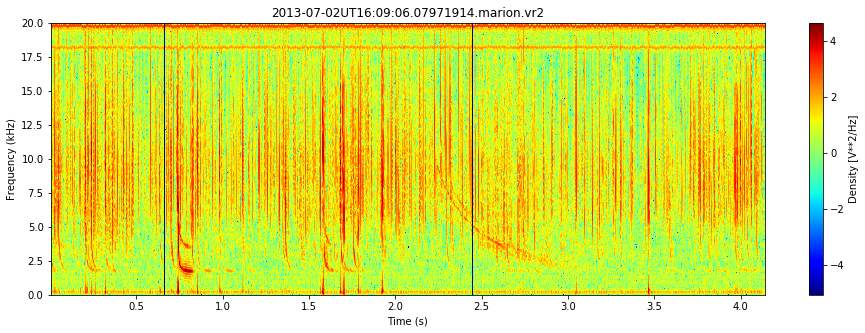

In [229]:
# generate specrtogram and save to dataset
for awd_event in range(1,awd_events):
    for site in sites:
        data_location = os.path.join(database_location, 'awdEvents'+str(awd_event), site, site+'_data')
        output_location = os.path.join(database_location, 'awdEvents'+str(awd_event))
        if os.path.exists(data_location):
            files = [ file for file in os.listdir(data_location) if file.endswith('.vr2')] # only select .vr2 file
            file = files[np.random.randint(len(files))]
#             file = "2013-07-07UT05:19:38.11811922.marion.vr2"
            print(file)
            output_data = extract_output(output_location, awd_event, site)[file]
            file_time = file[:27]
            outputs = []
            for key,value in output_data.items():
                outputs.append([round(datetime_diff(key,file_time),5), value])
            outputs = sorted(outputs, key=lambda x:x[0])
            
            whdf, fs =  vr2_to_panda(data_location, file, site)
            frequencies, times, spectrogram = spectrogram_gen(whdf, fs, 'density')
            print(spectrogram.shape)
            _t = np.round_(times,decimals=4)
            index = 0
            indices = []
            indexed_output = []
            for output in outputs:
                event_time = np.round(output[0],4)
                # find index of that event in the spectrogram
                index = min(range(len(_t)), key=lambda i: abs(_t[i]-event_time))
                # only process if the index found is new
                if index!=0 and index not in indices:
                    indices.append(index)
                    indexed_output.append([index, output[0], _t[index], output[1]])
#             events = sorted(outputs[:,1], reverse=True)[:len(indices)] # map prob to to event correctly
            print(output_data)
            print(outputs)
            print(indexed_output)
            for index_pb in indexed_output:
                spectrogram[:,index_pb[0]] = np.full(spectrogram[:,index_pb[0]].shape, spectrogram.min())
            
            # PRINT
            print("File name:", file)
            print("Time (output format); Time (s);Weight")
            for e in indexed_output:
                print(list(output_data.keys())[list(output_data.values()).index(e[3])],";",e[2],";",e[3])
            fig = plt.figure(figsize=(16,5))
            img = plt.pcolormesh(times,frequencies/1000,spectrogram, cmap='jet')
            fig.colorbar(mappable=img, label='Density [V**2/Hz]')
            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (kHz)')
            plt.title(file)
        break